## Generating Training and Test Data for the Mass-Spring-Damper Model 

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera as ct
from scipy.integrate import solve_ivp

import pyDOE

from PCAfold import PCA as PCAA

3.8.12 (default, Aug 31 2021, 04:09:21) 
[Clang 12.0.5 (clang-1205.0.22.9)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/MSD_100Cases/Orig'

NICs           = 100
POD_NAME       = '1'
iVar           = 0

if (POD_NAME == 'All'):
    NPODsFinal = 2
    PODType    = 'All'
else:
    NPODsFinal = 2
    PODType    = 'OneByOne'
try:
    os.makedirs(OutputDir+'/'+str(PODType))
except:
    pass


Vars   = ['x', 'v']
NVars  = len(Vars)

ValidPerc = 20

In [3]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        FileName             = OutputDir+'/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars]


        for iVar in range(NVars):
            if (np.abs( (DataTemp[Vars[iVar]][0] - DataTemp[Vars[iVar]][len(Data)-1])/DataTemp[Vars[iVar]][0] ) > 1.e-3): 
                DataICTemp  = Data[Vars].iloc[0]
                if (NewFlg):
                    DataInput        = DataTemp[Vars[iVar]]
                    if (iVar == 0):
                        DataIC           = DataICTemp
                    NewFlg           = False
                else:
                    DataInput        = pd.concat([DataInput, DataTemp[Vars[iVar]]], axis=1)
                    if (iVar == 0):
                        DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
                #Cols.append(str(iC+1))
                Cols = Cols+[str(iC+1)+'_'+Vars[iVar]]

    tVec              = Data['t']
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        FileName             = OutputDir+'/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars[iVar]]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-3):
            DataICTemp  = Data[Vars].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [4]:
ICs = DataIC.to_numpy()

In [5]:
DataInput.shape

(500, 100)

/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:212: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:212: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:212: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:212: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])
/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:212: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j,

(0.0, 10.0)

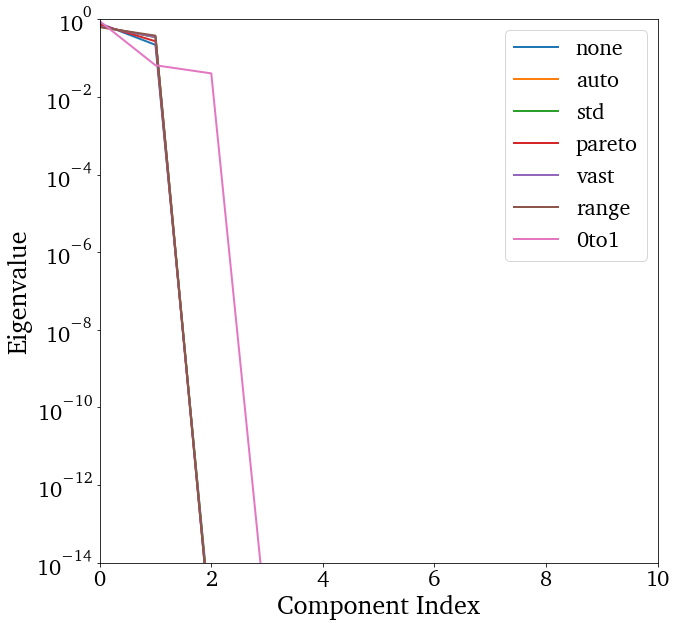

In [6]:
NPODs      = 64
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

plt.figure(figsize=(10,10))
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:NPODs].T
    L          = pca.L
    AT         = A.T

    plt.plot(L, label=Scaling)
    
plt.ylim([1.e-14, 1.e0])
plt.xlabel('Component Index')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
plt.xlim([0,10])

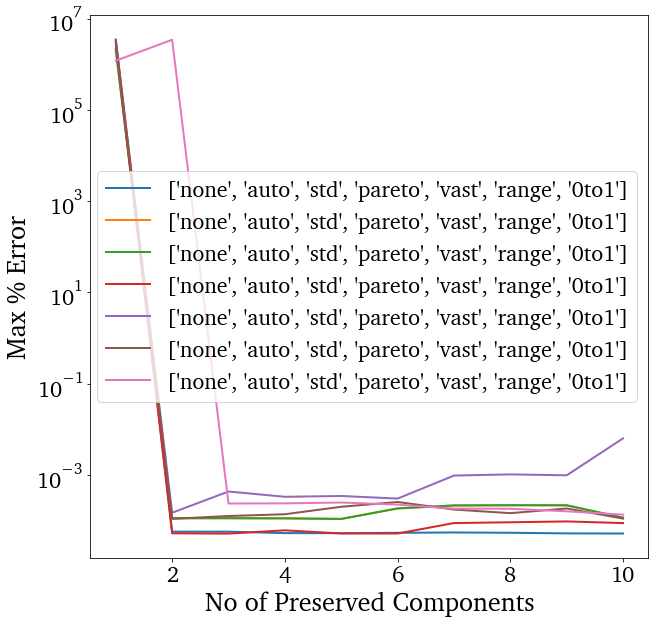

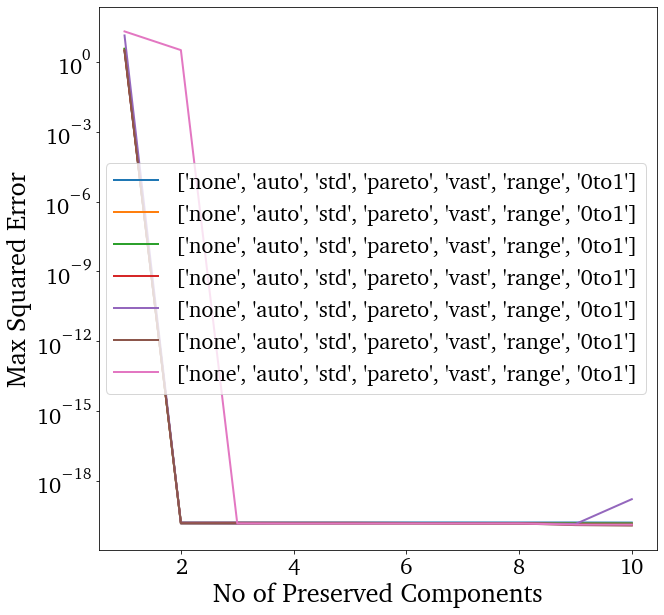

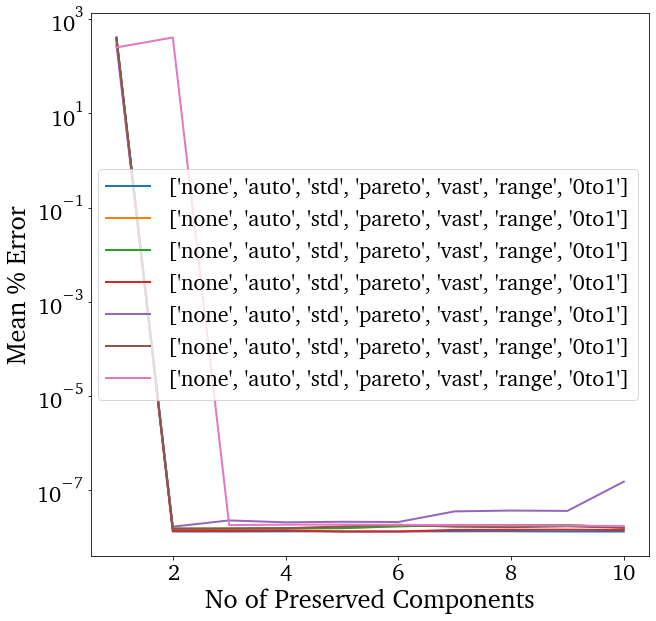

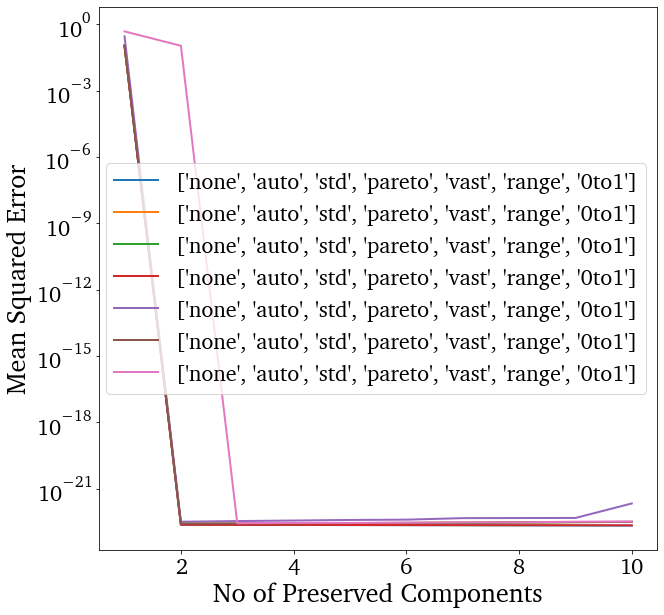

In [7]:
NPODsVec   = np.arange(1,11,1)
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

MaxPerc    = np.zeros((len(NPODsVec), len(ScalingVec)))
MaxSE      = np.zeros((len(NPODsVec), len(ScalingVec)))
MeanPerc   = np.zeros((len(NPODsVec), len(ScalingVec)))
MSE        = np.zeros((len(NPODsVec), len(ScalingVec)))
for i, NPODs in enumerate(NPODsVec):
    #print('NPODs = ', NPODs)
    
    for j, Scaling in enumerate(ScalingVec):

        pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
        C          = pca.X_center
        D          = pca.X_scale
        A          = pca.A[:,0:NPODs].T
        L          = pca.L
        AT         = A.T

        yMat_pca   = ((yMat - C)/D).dot(AT)
        yMat_      = (yMat_pca.dot(A))*D + C
        
        MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
        MaxSE[i,j]      = np.max((yMat - yMat_)**2)
        MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
        MSE[i,j]        = np.mean((yMat - yMat_)**2)

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MaxPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MaxSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Max Squared Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MeanPerc, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(10,10))
plt.plot(NPODsVec, MSE, label=ScalingVec)
plt.xlabel('No of Preserved Components')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

In [8]:
pca        = PCAA(yMat, scaling='none', n_components=NPODsFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODsFinal].T
L          = pca.L
AT         = A.T
yMat_Scaled= ((yMat - C)/D)
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (2, 100)
[PCA] 


In [9]:
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

FileName    = OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/yMat_Scaled.csv'
np.savetxt(FileName, yMat_Scaled, delimiter=',')

In [10]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 2)
[PCA]  Max % Error =  5.7308519424149763e-05
[PCA]  Max      SE =  1.6600548729016173e-20
[PCA] Mean % Error =  1.3346970998718754e-08
[PCA]          MSE =  2.341389671648064e-23


Text(0.5, 0, '$\\alpha_{x_2}$')

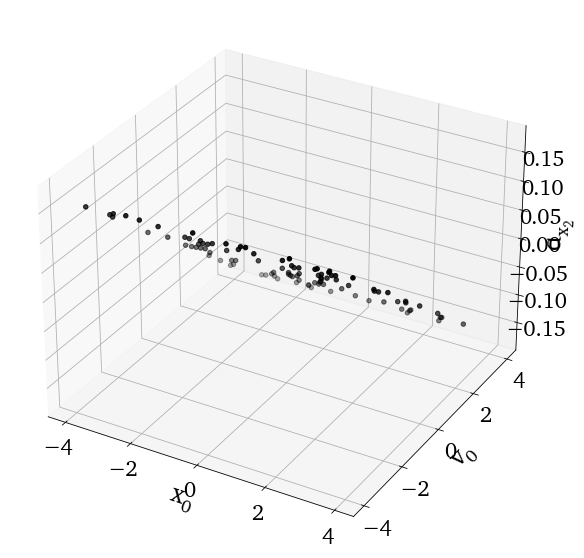

In [11]:
# %matplotlib qt

iVar    = 1

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')


fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
ax.set_xlabel(r'$x_{0}$')
ax.set_ylabel(r'$v_{0}$')
ax.set_zlabel(r'$\alpha_{x_'+str(iVar+1)+'}$')

Text(0, 0.5, '$\\psi_{2}$')

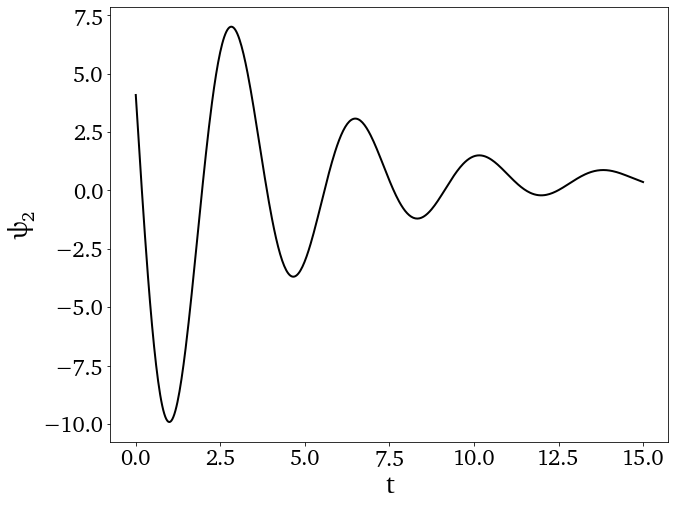

In [27]:
iVar = 1

plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xlabel('t')
plt.ylabel(r'$\psi_{'+str(iVar+1)+'}$')
#plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

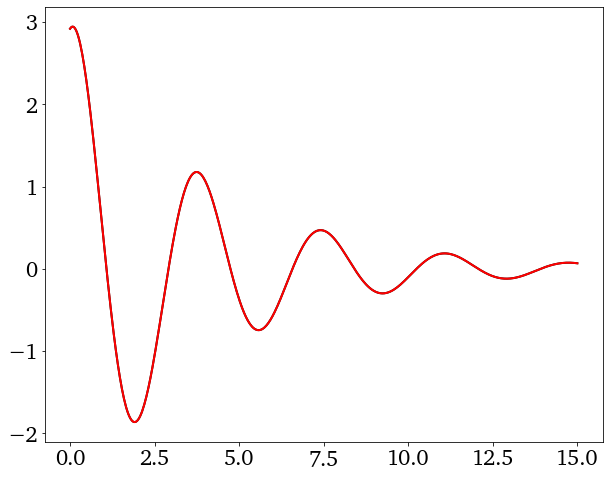

In [13]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat[:,1], '-k')
plt.plot(tVec, yMat_[:,1], '-r')
#plt.xscale('log')

In [14]:
VarsPOD          = ['POD_'+str(iPOD+1) for iPOD in range(NPODsFinal)]
Data             = pd.DataFrame(yMat_pca, columns=VarsPOD)
#tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,POD_1,POD_2,t,log(t),log10(t)
0,22.506308,4.091060,0.00000,-inf,-inf
1,22.498351,3.397864,0.03006,-3.504556,-1.522009
2,22.429191,2.707095,0.06012,-2.811409,-1.220979
3,22.299925,2.020575,0.09018,-2.405944,-1.044888
4,22.111798,1.340087,0.12024,-2.118262,-0.919949
...,...,...,...,...,...
495,0.249718,0.424719,14.87976,2.700002,1.172596
496,0.239036,0.408425,14.90982,2.702020,1.173472
497,0.227066,0.392502,14.93988,2.704034,1.174347
498,0.213860,0.376987,14.96994,2.706044,1.175220


In [15]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/')
except:
    pass

In [16]:
data_id    = 'pts'

DataNoZero           = Data#[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [17]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataInput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + VarsPOD]
DataOutput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [18]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass

In [19]:
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
except:
    pass

In [20]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [21]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Output.csv', index=False)

In [22]:
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/test/')
except:
    pass

In [23]:
data_id    = 'pts'

n_points             = len(DataIC)


# idx                  = np.arange(n_points)
# train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)
idx                  = np.arange(n_points)
train_idx            = idx
valid_idx            = idx

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/valid/'+data_id+'/Input.csv', index=False)

YY = np.zeros((A.shape[1],A.shape[1]), dtype=int)
for i in range(YY.shape[0]):
    YY[i,i] = 1
DataYY = pd.DataFrame(YY, columns=['IC_'+str(i+1) for i in range(YY.shape[0])])
DataYY.iloc[train_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/train/'+data_id+'/Output.csv', index=False)
DataYY.iloc[valid_idx].to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/valid/'+data_id+'/Output.csv', index=False)

In [24]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/test/ext/Input.csv', index=False)

YY = np.zeros((A.shape[1],A.shape[1]), dtype=int)
for i in range(YY.shape[0]):
    YY[i,i] = 1
DataYY = pd.DataFrame(YY, columns=['IC_'+str(i+1) for i in range(YY.shape[0])])
DataYY.to_csv(OutputDir+'/'+str(PODType)+'/POD_'+POD_NAME+'/Branch_ICs/test/ext/Output.csv', index=False)

In [25]:
iPOD       = 1

DataInput  = DataIC
DataZZ     = pd.DataFrame(A.T, columns=['POD_'+str(i+1) for i in range(A.shape[0])])

n_points             = len(DataIC)
idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

X          = DataInput.iloc[train_idx].to_numpy()
Y          = DataZZ.iloc[train_idx].to_numpy()[:,iPOD-1]#[...,np.newaxis]

XX         = DataInput.iloc[valid_idx].to_numpy()
YY         = DataZZ.iloc[valid_idx].to_numpy()[:,iPOD-1]#[...,np.newaxis]

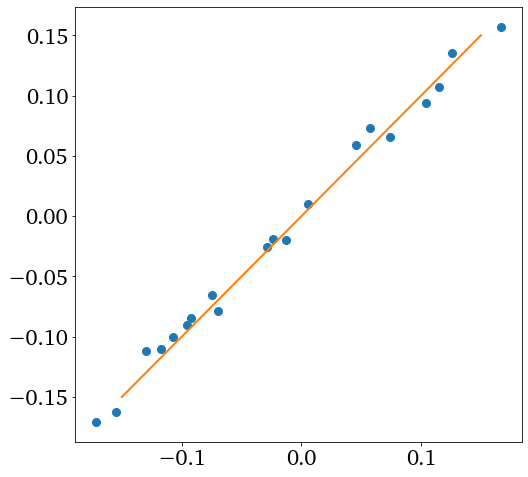

In [26]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)
neigh.fit(X, Y)

plt.figure(figsize=(8,8))
plt.plot(YY, neigh.predict(XX), 'o')
plt.plot([-0.15,0.15], [-0.15,0.15])